## Pendulum: One-step Method

In [13]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [14]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [16]:
model = 'pendulum'

### Cost function

Create `Kphiphi` to find the regularizer `R`

In [17]:
# Create Kphiphi
X = x_train_all.flatten()
sigma_K = jnp.mean(jnp.array([0.14840741, 0.88888889, 0.88888889]))
Kphiphi = Kphiphi_assembly( X[:e] , k = 'Gaussian', k_param = 0.5)

In [18]:
# Tr(Kphiphi)
trK = jnp.trace(Kphiphi[0:e,0:e])
# Tr(D^1D^1 Kphiphi)
trDDK = jnp.trace(Kphiphi[e:2*e,e:2*e])
# Tr(D^2D^2 Kphiphi)
trD2D2K = jnp.trace(Kphiphi[2*e:3*e,2*e:3*e])
# First block
ones = jnp.ones((e))
# Second block
second = ones*trDDK/trK
# Third block
third = ones*trD2D2K/trK
# Assemble R or take the diagonal or Kphiphi
diagonal = jnp.concatenate((ones,second,third))
R = jnp.diag(diagonal)

Create objective function `L`

In [19]:
def L(Z, X, U, f, R, lmbd):
    """Cost function for one step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrix that regularizes Kphiphi
    Returns:
        scalar: a cost of this solution.    
    """ 
   
    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N)
    sigma_Gamma = 1.35 # From 2-step
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    alpha_Gamma = 1e-13 # nugget from 2-step !!!
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    rkhs_P = 63.55198060496819
    L1 = jnp.dot(f.T , b) / rkhs_P
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    sigma_K = jnp.mean(jnp.array([0.24994344, 0.74908123, 0.74908123])) # From 2-step
    Kphiphi = Kphiphi_assembly( X[:e] , k = 'Gaussian',k_param = sigma_K)
    alpha_K = 1e-6
    Kphiphi = Kphiphi + alpha_K*R 
    #print("cond(Kphiphi) = ", jnp.linalg.cond(Kphiphi))

    rkhss = [1.0878018748947793, 3.180451099204698, 11.67100972299891]
    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[e*i:(i+1)*e,:].T,(e*3,1))
        c = jnp.linalg.solve(Kphiphi,Z_i)
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i]

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Gradient descent

Training data

In [20]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(e*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [21]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(e*m,1),u_xx_pred_train.T.reshape(e*m,1)])

In [22]:
L(Z_warm, X, U, f, R, lmbd = 1/3)

Array(335993.81276367, dtype=float64)

Which `lmbd` in the expression `L1 + lmbd*L2` should I use if `L1` >> `L2` ?

In [23]:
lmbd_min = 1/3 # It always picks the smallest here 

Initialize the grad functions with `jit` to be efficient

In [24]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, f,R,lmbd= lmbd_min)
# Warm start here !!!

Array([[ 4.25701544e+03,  5.60842807e+02],
       [ 2.94336248e+04,  3.64581442e+03],
       [-3.45201608e+04,  1.13746069e+03],
       [-1.10198384e+03, -5.43957381e+01],
       [-1.40504759e+03,  1.00119529e+02],
       [-2.46424144e+02,  1.60076091e+01],
       [-2.79015740e+03, -1.42763254e+02],
       [-9.90880051e+03,  4.76898844e+01],
       [-1.79570852e+03, -9.60573627e+01]], dtype=float64)

Run the gradient descent for `100` epochs

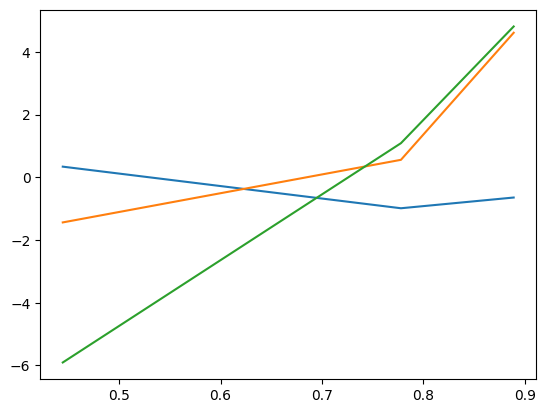

In [25]:
# Sanity check here!
plt.plot(x_train[0:e], U[0:e])
plt.plot(x_train[0:e], u_x_pred_train[0:e,0])
plt.plot(x_train[0:e], u_x_train[:,0])
plt.show()

### Gradient descent

In [26]:
# Only do this for the first time - 
Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

In [36]:
# If trained previously use Z
if np.all(Z != Z_warm):
    Z = np.load('data/Z.npy')
else:
    Z = np.copy(Z_warm)
learning_rate = 1e-3
for i in range(1000):
    delta_Z = grad_Z(Z, X, U, f,R,lmbd=lmbd_min)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    if i % 10 == 0:
        print(L(Z, X, U, f, R, lmbd=lmbd_min))
        # Load true gradients from 2-step
        u_x_train = np.load('data/u_x_train.npy')
        u_xx_train = np.load('data/u_xx_train.npy')
        # Build true Z
        Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])
    # if i == 0:
    #     fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
    #     ax1.set_title(r'$\partial_x$ sine')
    #     ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
    #     ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
    #     ax1.legend()
    #     ax2.set_title(r'$\partial_{xx} sine$')
    #     ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
    #     ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
    #     ax2.legend()
    #     ax3.set_title(r'$\partial_x$ poly')
    #     ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
    #     ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
    #     ax3.legend()
    #     ax4.set_title(r'$\partial_{xx}$ poly')
    #     ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
    #     ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
    #     ax4.legend()
    #     ax5.set_title(r'$\partial_x$ exp')
    #     ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
    #     ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
    #     ax5.legend()
    #     ax6.set_title(r'$\partial_{xx}$ exp')
    #     ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
    #     ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
    #     ax6.legend()
    #     plt.show()
        
# Save at the end of iterations
np.save('data/Z.npy',Z)

17787.102599282665
17753.003001129393
17719.14482636347
17685.523504828558
17652.13457529808
17618.973682639895
17586.036575058588
17553.31910141374
17520.817208611938
17488.526939069914
17456.44442824744
17424.56590224771
17392.88767548333
17361.40614840588
17330.117805297847
17299.01921212393
17268.107014441903
17237.377935369357
17206.82877360618
17176.45640151063
17146.257763227273
17116.229872866123
17086.369812730492
17056.674731593033
17027.14184301826
16997.76842373006
16968.551812023525
16939.48940621906
16910.578663158456
16881.817096740822
16853.202276498134
16824.73182620859
16796.40342254733
16768.21479377285
16740.163718448614
16712.24802419872
16684.465586496437
16656.814327485183
16629.29221483058
16601.897260602826
16574.627520188926
16547.48109123339
16520.456112606815
16493.550763401967
16466.763261955875
16440.091864897862
16413.534866222293
16387.09059638598
16360.7574214287
16334.533742117228
16308.417993111061
16282.408642150413
16256.504189264968
16230.703166003

## Evaluation of `Z`

In [37]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])

> One-step Method vs Truth

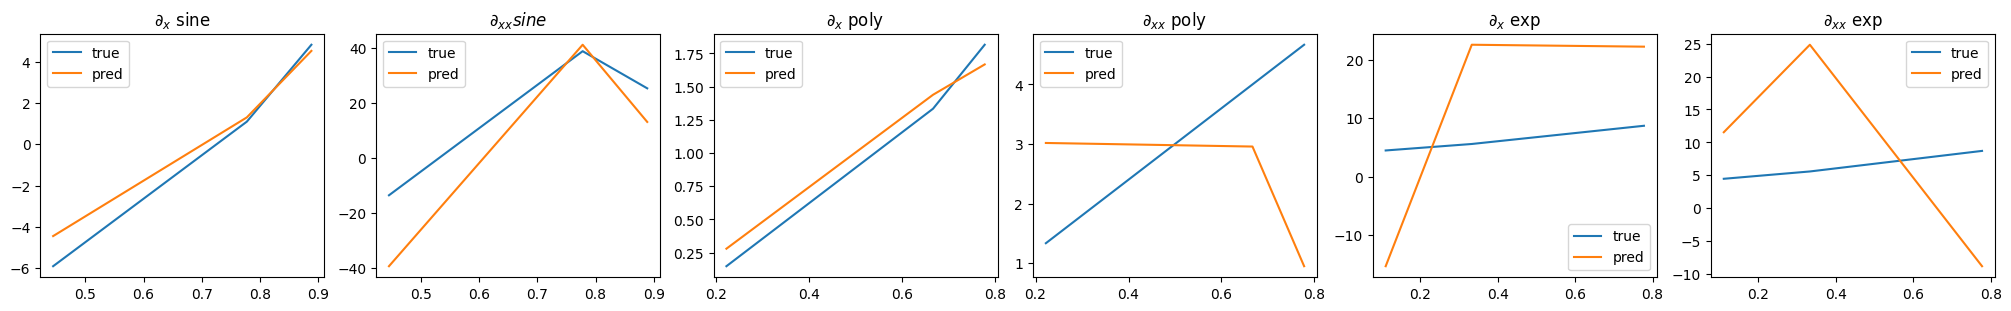

In [38]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

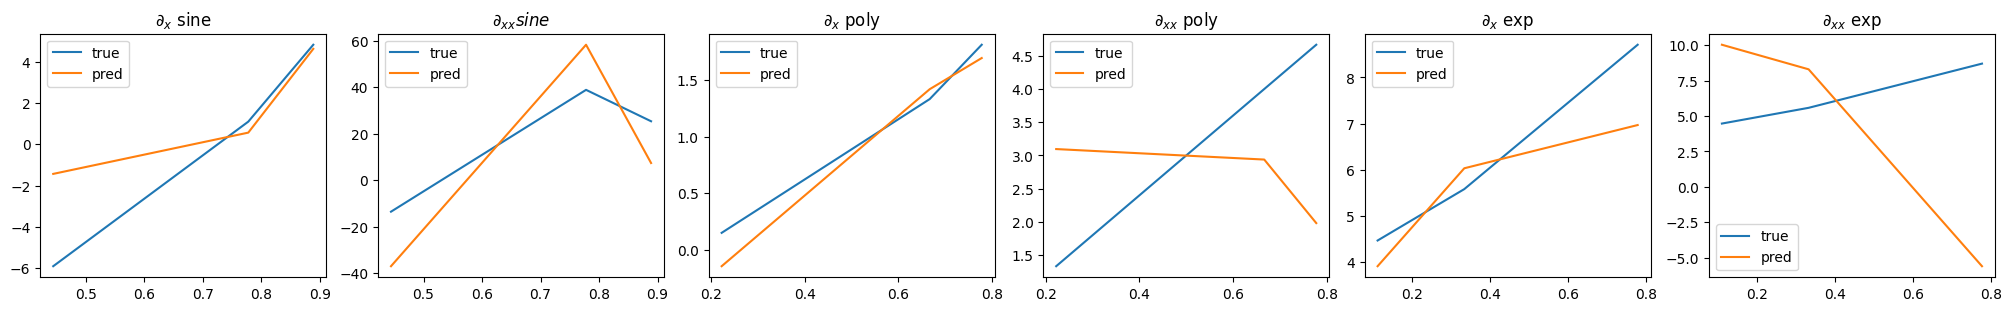

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z_warm[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z_warm[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z_warm[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z_warm[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()